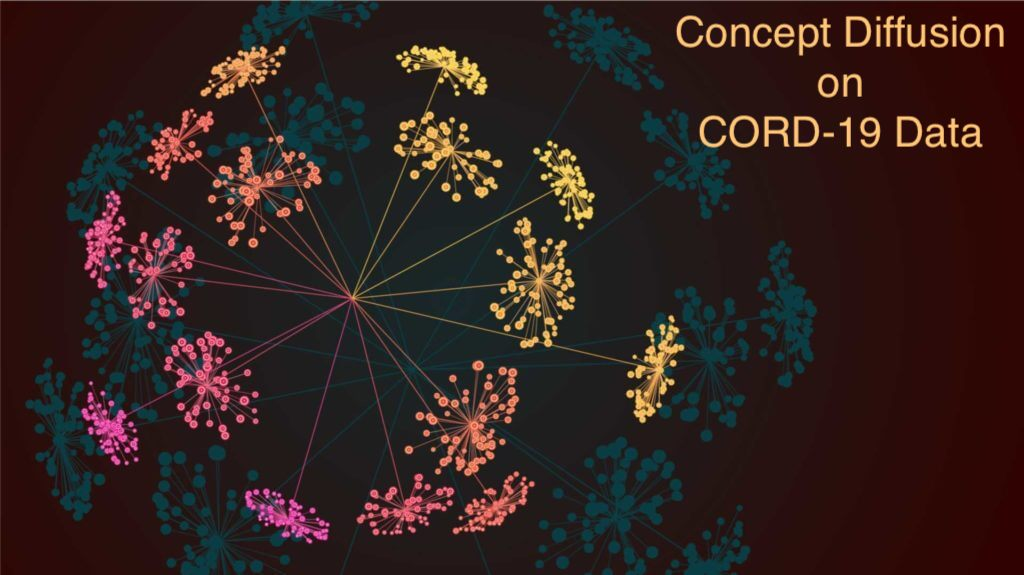

This is a joint project by Avinash Vyas and Dan Kushnir with contributions from Joerg Abendroth

© 2020 Nokia
Licensed under the BSD 3-Clause License
SPDX-License-Identifier: BSD-3-Clause

# GOAL
COVID-19 Open Research Dataset Challenge has 10 Tasks where each task has several sub tasks. For each subtask or question related to the subtask we aim to find the most relevant papers/articles thus saving time and effort of researchers and doctors. For e.g. the tool can be used to find documents that are contextually associated with specific medical questions for any of the task such as, What is the target of a drug x?, Which drugs have similar effect?, Does cold weather cause faster spread?, Which protective equipment reduce covid transmission?, Does smoking increase fatality? Are pets susceptible to spill over? or Does increased testing enhance containment?



# Approach
We will be using Universal Sentence Encoder (USE) to compute embeddings/representation of all the abstracts and tasks (and subtasks) and then match a subtask (or a related question) to abstracts in this embeddings space using cosine similarity. Next, we build a graph using the USE-embeddings. The graph G(V,E,w), whose nodes correspond to the documents and its edges are constructed according to a K-nearest neighbor search in a further reduced space. Specifically we use TSNE to reduce the encoded dimension and then we assign the edges with weights according to the proximity in the reduced space.

At the basis of our approach is the assumption that the reduced space preserves the semantic relationship encoded by the USE. To this end, we can introduce a search mechanism that uses the graph to learn association between different concepts (e.g. therapeutics) to answer various question, as specific as "what is the target of drug x?" or "which drugs are used in combination to treat covid-19 patients?"

The search mechanism employs several stages:
1. Concept Match:A match document (or batch of documents) for each prescribed concept of interest is found among the documents which cover covid-19 as well. The corresponding match is found by similarity in the encoding space.
2. Diffusion: the corresponding matching nodes in the graph are labeled with a weight and the weights is diffused to the neighboring nodes, and further from those neighboring nodes to the neighbors and so on. The weighted are transduces using a Markov process that uses transition probabilities from the normalized edge weights.
3. Concept intersection: We use the set of nodes that have been reached with weighted labels from the original concept matching node(s) to represent the that concept. We then find all intersection between such concept sets to infer target documents that represent the interaction between the concepts. 
4. Report and visualization: We report the pairwise concept intersection sets. Specifically, we report the article id (aid) and its title. We also plot two-dimensional visualization of the TSNE-embedding for each concept and the diffusion sets around each concept match. 
 

To Demonstrate our approach we present below a visualized output of 4 concepts that were matched and diffused in the TSNE embedding of the USE representation. In this case we selected rather specific concepts including the two drugs Chloroquine and Hydroxycloroquine (its derivative) which known for Malaria treatment. The drug Ritonovire and the Viral target protein Nucelocapsid. In each sub figure the diffused sets are observed for concept. We used 5-top-rankging matches for each concept and diffused their labels for 4 edge-hops. 

The following observations are noted:
1. Chloroquine (CHL) and Hydroxycloroquine (HCHL) (a drug and its derivative) are found with a strong intersection for most matches. Typically, they are found in clusters representing both combined therapies and in proximity in regions of articles focusing on the specific drug therapy.
2. We also find  CHL in a separate match representing combination with Chinese medicine.
3. Ritonovir is found in the regions where combined therapies are used, intersecting with CHL and HCHL, and also in proximity and some intersection with its target the Nucleocpasid.
4. we observe some anomalous match for the Nucleocpasid concept whose abstract contains a single line.

We conclude that the USE embedding preserves semantics and the diffusion process employed can be used to answer various questions related to various tasks in the challenge scope regarding interactions between concepts, and general search for relevant literature on the concept.

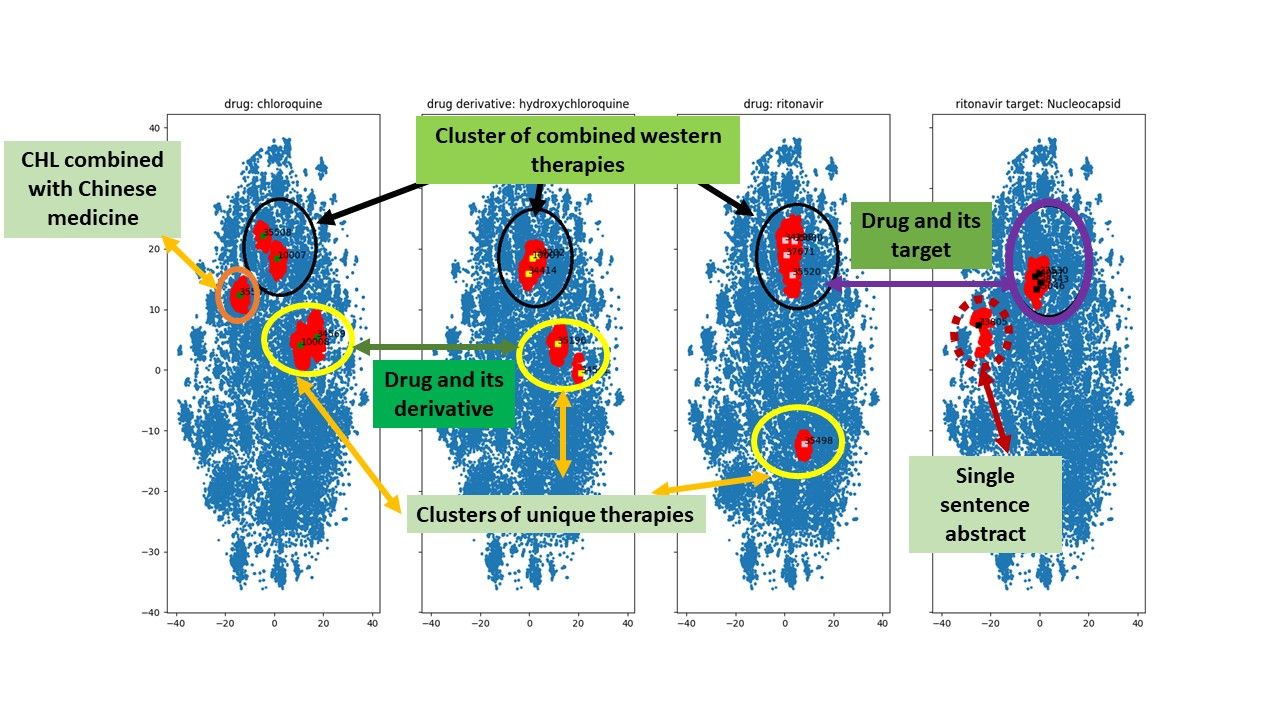

# Description
We have built a pipeline of the following processing modules 
1. **ETL** - extract a representation of each article in the CORD-19 data corpus,
2. **Encoding** - compute the Universal Sentence Encoder (USE) encoding of the extracted representation of each article. (This is a computationaly expensive step which takes 2-3 hours. To save time we have precomputed embeddings for 37k abstracts and uploaded them as input data source. To use them instead of computing them, please skip the step marked as optional below and uncomment the filename pointing to the input data)
3. **Representation** - use the deep-encoding to create a contextual graph
4. **Seed Generation** - use the sub-task or a related question to find top-k matching articles from the CORD-19 data corpus
5. **Diffusion** - using the top-k matches as seed, use the process of diffusion on the graph to find contextually similar document. Reports the sets of intersection, and a visualization.

In [ ]:
pip install pickledb

In [ ]:
import json
import pandas as pd

def extractData(csvfile, jsonfile):
    data = pd.read_csv(csvfile) # add exception handling incase filepath it wrong or does not exists
    data_with_abstract = data[data.abstract.notnull()]
    with open(jsonfile, 'a+') as json_out_file:
        for index, row in data_with_abstract.iterrows():
            json_data = {}
            json_data["id"] = index
            json_data['articleID'] = row['cord_uid']
            json_data["text"] = row['abstract']
            if json_data["text"] == "Unknown":
                continue
            json.dump(json_data, json_out_file)
            json_out_file.write('\n')
    print("Done !!!")
            
inputfile = "/kaggle/input/CORD-19-research-challenge/metadata.csv"
outputfile = "covid-19.json"

extractData(inputfile, outputfile)

Next we compute the USE embeddings of all the abstracts and store them in a pickle file. We will also store the corresponding abstract in a pickleDB file. For this we are going to use two classes (shown below) that provides the abstractions to manage the embeddings (EmbeddingStore) and the abstracts (ParaStore). The two classes allow us to save, retrive and compute top-k matching abstract for any input sentence.

In [ ]:
import tensorflow_hub as hub
import numpy as np
import pickle
import pickledb
import random

class EmbeddingStore:
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

    def __init__(self, filename):
        self.embedding_file = filename
        self.all_docs_embeddings = self.read_embeddings()
        if self.all_docs_embeddings is None:
            print("all_docs initialized to None")

    def save_embeddings(self):
        f = open(self.embedding_file, 'wb')
        pickle.dump(self.all_docs_embeddings, f)

    def read_embeddings(self):
        try:
            f = open(self.embedding_file, 'rb')
        except FileNotFoundError:
            return None
        try:
            embeddings_ = pickle.load(f)
        except EOFError:
            embeddings_ = None
        return embeddings_

    def add_embeddings(self, new_embeddings_):
        if self.all_docs_embeddings is None:
            combined_embeddings_ = new_embeddings_
        else:
            combined_embeddings_ = np.concatenate((self.all_docs_embeddings, new_embeddings_))
        self.all_docs_embeddings = combined_embeddings_

    def dump(self):
        self.save_embeddings()

    def add_para(self, new_para_):
        new_embeddings_ = self.embed([new_para_])
        self.add_embeddings(new_embeddings_)

    def find_top_k_match(self, query, k):
        #print("Query received = {}".format(query))
        query_embedding_ = self.embed(query)
        #print(query_embedding_.shape)
        #print(query_embedding_[0].shape)
        #print(self.all_docs_embeddings.shape)
        corr = np.inner(query_embedding_[0], self.all_docs_embeddings)
        #print(corr)
        values = np.argpartition(corr, -k)[-k:]
        #print("Top K matches for = {} at {}".format(query, values))
        return values

class ParaStore:

    def __init__(self, docsfilename, embeddingsfile):
        self.docfile = docsfilename
        self.embeddingstore = EmbeddingStore(embeddingsfile)
        self.all_docs = self.read_para()
        self.nos_docs = self.all_docs.totalkeys()
        print("There are {} docs in the store".format(self.nos_docs))

    def save_para(self):
        self.all_docs.dump()

    def read_para(self):
        docs = pickledb.load(self.docfile, False)
        return docs

    # Changed this function to use the aid instead of text
    def already_exists(self, new_para):
        allkeys = self.all_docs.getall()
        for key in allkeys:
            if new_para["aid"] == self.all_docs.get(key)["aid"]:
                print("{} already in the doc store".format(new_para["aid"]))
                return True
        return False

    def add_para(self, new_para):
        text = new_para["text"]
        if not self.already_exists(new_para):
            self.all_docs.set(str(self.nos_docs), new_para)
            self.embeddingstore.add_para(text)
            self.nos_docs = self.nos_docs+1
            if self.nos_docs % 1000 == 0:
                self.dump()
    def dump(self):
        self.all_docs.dump()
        self.embeddingstore.dump()

    def get_para(self, nos):
        return self.all_docs.get(str(nos))

    def get_matching_para(self, query):
        pos = self.embeddingstore.find_top_match(query)
        match = self.get_para(pos)
        return match

    def get_matching_k_para(self, query, k):
        positions = self.embeddingstore.find_top_k_match(query, k)
        matches = {}
        for i in positions:
            match = self.get_para(i)
            matches[str(i)] = match
        return matches

    def filter_k_randomly(self, matches, k):
        kmatches = {}
        #print("Filtering {} from {} matches".format(k, len(matches)))
        if len(matches) <= k:
            return matches
        else:
           indexes = random.sample(matches.keys(), k)
        for i in indexes:
            kmatches[i] = matches[i]
        return kmatches

    def applyFilter(self, filt, text):
        for name in filt:
            if text and name.lower() in text.lower():
                return True
        return False
        
    def get_including_k_para(self, query, filt, k):
        matches = {}
        allkeys = self.all_docs.getall()
        for key in allkeys:
            candidate = self.all_docs.get(key)
            if (query[0] in candidate["text"]) and (self.applyFilter(filt, candidate["text"])):
                matches[key] = candidate
        kmatches = self.filter_k_randomly(matches, k)
        return kmatches



# Compute Embeddings (Optional)
The next step computes the USE embeddings for all the abstracts and store them. Its take considerable time (2-3 hours) to compute these embeddings therefore we have pre-computed the embeddings of 37K abstracts and uploaded them as a dataset. **This is a optional step****.

In [ ]:
def openStore(docfile, embedding_file):
    docstore = ParaStore(docfile, embedding_file)
    return docstore

def importFromDrqa(filename, dbfile, embedfile):
    docstore = openStore(dbfile, embedfile)
    with open(filename) as f:
        line = f.readline()
        while line:
            para = {}
            #print(line)
            data = json.loads(line)
            #print(data["id"])
            para["aid"] = data["articleID"]
            para["text"] = data["text"]
            docstore.add_para(para)
            line = f.readline()
        docstore.dump()
        
filename = "covid-19.json"
pickledbfile = "cord19.db"
embedfile = "cord19.pkl"

importFromDrqa(filename, pickledbfile, embedfile)
print("All Document Imported")

# Seed Generation
Next we find top-k match to a input query text, in the USE emebedding space (using cosine similarity). Here we use as input a list of concepts extracted from the CORD-19 dataset (including medications and proteins of the virus) and find the top-5 matching abstracts to these concepts. The output is saved in a CSV file that is used in the next step as a seed for diffusion process on the knowledge graph. 

If the optional step of computing the embeddings have been executed there is no change to made and the next step can run as-is. If one wants to use the pre-computed embeddings then it needs to uncomment the 

In [ ]:
import csv
import json

def openStore(docfile, embedding_file):
    docstore = ParaStore(docfile, embedding_file)
    return docstore

def getTopKMatch(dbfile, embedfile, query, k=1):
    # open the store
    query_vector = [query]
    print("The query vector is {}".format(query_vector))
    docstore = openStore(dbfile, embedfile)
    matches = docstore.get_matching_k_para(query_vector, k)
    return matches

def getTopKStringMatch(dbfile, embedfile, filt, query, k=1):
    # open the store
    query_vector = [query]
    print("The query vector is {}".format(query_vector))
    docstore = openStore(dbfile, embedfile)
    matches = docstore.get_including_k_para(query_vector, filt, k)
    return matches

def createBigRow(med, indexes, aids, abstracts):
    print("Creating a big row of {}, {}, {}".format(med,indexes,aids))
    big_row = list()
    big_row.append(med)
    for i in indexes:
        big_row.append(i)
    for i in aids:
        big_row.append(i)
    for abs in abstracts:
        big_row.append(abs)
    return big_row

def pad2K(data, k):
    if len(data) >= k:
        return data
    else:
        for i in range(len(data), k):
            data.append("None")
    return data

covid19_names = {
    'COVID19',
    'COVID-19',
    '2019-nCoV',
    '2019-nCoV.',
    'coronavirus disease 2019',
    'Corona Virus Disease 2019',
    '2019-novel Coronavirus',
    'SARS-CoV-2',
}

def evalQueryDetailCSV(filename, outfile, match):
    with open(filename) as f, open(outfile, 'w') as output:
        filewriter = csv.writer(output, delimiter=',')
        line = f.readline()
        while line:
            line = line.replace("\'", "\"")
            data = json.loads(line)
            q_id = data['id']
            q = data['text']
            med = q
            if match == 'USE':
                topk = getTopKMatch(paraFile, embeddingFile, q, 5)
            else:
                topk = getTopKStringMatch(paraFile, embeddingFile, covid19_names, q, 5)
            indexes = []
            aids = []
            abstracts = []
            for key in topk.keys():
                indexes.append(key)
                para = topk.get(key)
                aids.append(para["aid"])
                #print(para["aid"])
                abstracts.append(para["text"].encode('utf-8'))
                #print(para["text"].encode('utf-8'))
            indexes = pad2K(indexes, 5)
            aids = pad2K(aids, 5)
            abstracts = pad2K(abstracts, 5)
            big_row = createBigRow(med, indexes, aids, abstracts)
            filewriter.writerow(big_row)
            line = f.readline()

# if using the embeddings computed by the notebook uncomment these 4 lines
#queryFile = "/kaggle/input/medicinenames/drugs-only.json"
#paraFile = "cord19.db"  
#embeddingFile = "cord19.pkl" 
#evalQueryDetailCSV(queryFile, "top-5.csv", 'string')

# if using the precomputed embeddings uncomment these 4 lines (and comment out the above 4 lines)
queryFile = "/kaggle/input/medicinenames/drugs-only.json"
paraFile = "/kaggle/input/embeddings/cord19.db"  # Use precomputed embeddings, this is to save time
embeddingFile = "/kaggle/input/embeddings/cord19.pkl" # Use precomputed embeddings, this is to save time
evalQueryDetailCSV(queryFile, "top-5.csv", 'string')



We are displaying titles in the contextual graph therefore we add the title to the result obtained above i.e. the seed file.

In [ ]:
import pandas as pd
import csv

def findDocIds(row):
    data = row.tolist()
    return data[6:11]

metadatafile = "/kaggle/input/CORD-19-research-challenge/metadata.csv"
inputfile = "top-5.csv"
outputfile = "top5-with-abstract.csv"

output = open(outputfile, "w")
filewriter = csv.writer(output, delimiter=',')
metadata = pd.read_csv(metadatafile)
input_data = pd.read_csv(inputfile, header=None)
for index, row in input_data.iterrows():
    docids = findDocIds(row)
    print(docids)
    titles = list()
    for docid in docids:
        if docid != 'None':
            cand = metadata[metadata["cord_uid"] == docid]
            title = cand["title"].values[0]
        else:
            title = 'None'
        titles.append(title)
    x = pd.Series(titles)
    print(x)
    newrow = row.append(x)
    filewriter.writerow(newrow)

# Contextual Graph and Diffusion
We compute the contextual graph and use diffusion with the seed obtained from top-k match. Several parameters are set within the program which can be further tuned per user.

sigma (= 1) - distance normalization for the weights

mode (= 0): controls the use of sparse data structure

sparse_mode (= 0): 

knnfile = (''): if set to 'knn' we look for the file 'knn n_neighbors' with prior-computed KNN data to save computing time (avoiding computing KNN is typically not needed unless the reduced data is a high dimension which may take more time to compute if program is invoked several times). If n_neighbors value is changing to new value the user has to use '' to compute the graph from scratch.

n_neighbors (= 14): number of nearest neighbors for graph construction (KNN). Since currently graph is constructed at low dimension can be set between 10-30

TSNE_done (= 0): if 1 TSNE is attmpted to be read from a precomputed file, assuming that it exists, to save on the TSNE computation. 

titer = 3: number of diffusion iterations (hops). These critical parameters controls the rate of expansion of labels around the seeded matches. if too high may collect documents that might have little contextual link to the matches. Yet, has a higher chance of intersecting with other concepts.

Please note that in order to assign concepts to the program you need to do it in the code below in the array 'meds'. Right now it is configured as

    meds = ['chloroquine','hydroxychloroquine','ritonavir','Nucleocapsid']



In [ ]:
pip install MulticoreTSNE

In [ ]:
import pickle
import pickledb
import argparse
import sys
import time
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
import csv
import pandas
 
 
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
from scipy.sparse.linalg import eigs
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import SpectralEmbedding
 
 
 
def read_embeddings(file):
        try:
            f = open(file, 'rb')
        except FileNotFoundError:
            return None
        try:
            embeddings_ = pickle.load(f)
        except EOFError:
            embeddings_ = None
        return embeddings_
 
def read_para(self):
        docs = pickledb.load(self.docfile, False)
        return docs
 
def get_para(self, nos):
        return self.docs.get(str(nos))
 
def make_graph(x, n_neighbors, mode, sparse_mode, sigma, knnfile, nrmd):
    '''
    ***
   
    inputs:
 
    x: the data (np.array)
    args: args: the input arguments to the script
    nrmd: if we want the graph matrix to be normalized
    outputs:
 
    a: the diffusion matrix (scipy.csr_matrix)
 
    ***
    '''
    n = x.shape[0]
    print(knnfile)
    # construct kneighbors graph from data
 
    if (id(knnfile) == id('')):
        print('computing knn\n')
 
        start_time = time.time()
        a = kneighbors_graph(x, n_neighbors, mode='distance')
        print("--- %s seconds ---" % (time.time() - start_time))
        print(a.shape)
        with open('knn'+str(n_neighbors), 'wb') as wfile:
            pickle.dump(a,wfile)
    else:
        with open('knn'+str(n_neighbors), 'rb') as rfile:
            a = pickle.load(rfile)                          
    # simmetrize it
 
#print(a[[1,2],:])
    a = a + a.transpose()
#a = np.expm1(-a)
#a = a-a.sign()
#if args.sparse_mode: a = a + sparse.eye(n)
 
#print(a[[1,2],:])
 
    if (nrmd):
 
        # get the un-normalized weight matrix
        norm = (a * sigma).max(axis=1).todense()
 
        norm = 1. / norm
        a = - a.multiply(norm)
        a = a.expm1()
        a = a - a.sign()
        if sparse_mode: a = a + sparse.eye(n)
 
        # get the normalized weight matrix
        p = a.sum(axis=1)
        p = 1. / p
        a = a.multiply(p)
        assert a.sum() == n # sanity check
    return a
 
 
class diff_vecs: 
    def __init__(self, name, roll): 
        self.name = name 
        self.vec = vec
   
 
 
def diffuse_labels(y=None, train_indices=None, g=None, t=1, class_=1):
    '''
    ***
   
    inputs:
 
    y: the labels (np.array)
    train_indices: the indices of the train dataset (list)
    g: the graph (scipy.csr_matrix)
    t: how many diffusion steps (int)
 
    outputs:
 
    signal: the soft labels from diffusion (np.array)
 
    ***
    '''
    n = len(y)
 
    # get training data labels and normalize in [-1,1]
    y = y[train_indices]
    y = 2 * (y == class_).astype(np.float) - 1
    # get the signal to diffuse
    signal = np.zeros((n))
    signal[train_indices] = y
 
    # diffuse t times
    for _ in range(t):
        signal = g.dot(signal)
        signal[train_indices] = y
    return signal
 
def plot_diff(title,fig_ax, x, signal,training_idx,text,color):
    print('Plotting results')
    fig_ax.scatter(x[:, 0], x[:, 1], s=2**2)
    heatmap = signal[signal>0]
    cmap = 'bwr'
 
 
    for ix in training_idx:
        print(ix)
        fig_ax.text(x[ix,0],x[ix,1], str(ix))
 
    fig_ax.set_title(title, fontsize='x-large')
    fig_ax.scatter(x[signal>0,0], x[signal>0,1],color = 'red')
 
    fig_ax.scatter(x[training_idx,0], x[training_idx,1], marker='s',  color = color)
 
    return(fig_ax)
 
# Function to lookup title for notebook
def findTitle(pos, paraFile=None, metadataFile=None):
    if not paraFile:
        paraFile = "/kaggle/input/embeddings/cord19.db"
    if not metadataFile:
        metadataFile = "/kaggle/input/CORD-19-research-challenge/metadata.csv"
       
    docs = pickledb.load(paraFile, False)
    para = docs.get(str(pos))
    docid = para["aid"]
    metadata = pandas.read_csv(metadataFile)
    cand = metadata[metadata["cord_uid"] == docid]
    title = cand["title"].values[0]
    return docid, title
 
 
def main(embeddingFile, seedFile, n_neighbors, mode, sparse_mode, sigma, knnfile, TSNE_done):
    data = read_embeddings(embeddingFile)
    #print(data[[0,1],:])
    n = data.shape[0]
    print(n)
 
    #try TSNE
 
    print('starting TSNE')
    print(TSNE_done)
    if (TSNE_done == 0):
        print('Doing TSNE')
        X_embedded = TSNE(n_jobs=4).fit_transform(data)
        #with open('/kaggle/input/tsnedata/tsne'+str(n_neighbors), 'wb') as wfile:
        with open('tsne'+str(n_neighbors), 'wb') as wfile:
            pickle.dump(X_embedded,wfile)
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
            plt.show()
    else:
        with open('tsne'+str(n_neighbors), 'rb') as rfile:
            X_embedded = pickle.load(rfile)
 
 
    #creating the graph and intiating diffusion:
    print('Creating graph, and starting diffusion process\n')
 
    g=make_graph(X_embedded, n_neighbors, mode, sparse_mode, sigma, knnfile, nrmd = 1)
    df = pandas.read_csv(seedFile,header=None)
    meds = ['chloroquine','hydroxychloroquine','ritonavir','Nucleocapsid']#,'lopinavir/ritonavir','lopinavir']
    titles = ['drug: chloroquine','drug derivative: hydroxychloroquine','drug: ritonavir','ritonavir target: Nucleocapsid']#,'lopinavir/ritonavir','lopinavir']
    colors = ['green','yellow','pink','black','brown','grey']
    count = 0
 
    fig, ax_array = plt.subplots(1, len(meds), sharex=True, sharey=True)
 
 
    print('diffusion loop')
    a = []
    for med in meds:
        med_idx = df.index[df[0] == med]
        #med_idx = np.where(df[0] == med)
        print('med is:' + med)
        print('med_idx:' + str(med_idx))
        seed_idx = df.values[med_idx,[1,2,3,4,5]]
        seed_idx = seed_idx.astype(int)
        med_name = med
        print('seed_idx:' + str(seed_idx))
        y = np.ones(n, dtype=int)
        y.astype(int)
        signal = diffuse_labels(y=y, train_indices=seed_idx, g=g, t=titer, class_=1)
        a.append(np.asarray(np.where(signal>0)))
        # list = []
        # list.append(diff_vec(med,np.where(signal>0)))
        #print(np.where(signal>0))
        color = colors[count]
        ax_array[count] = plot_diff(titles[count],ax_array[count], X_embedded, signal,seed_idx,med_name,color)
        count = count+1
        # print out the interactions
        
    print(len(a))
        
    for i in range(len(meds)):
        vec1 = a[i]
        # print('vec1_len is:' + str(vec1.shape[1]))
        # print('vec1:' + str(vec1))
        for j in range(i+1,len(meds)):
            vec2 = a[j]
            #print('vec2:' + str(len(vec2)))
            insct = np.intersect1d(vec1,vec2)
            print('----------------------------------------------------------------------------------------------------------\n')
            print('intersection of concept ' + meds[i] + ' and concept ' + meds[j] + '\n')
            for pos in insct:
                #id, tit = findTitle(pos, paraFile='cord19.db', metadataFile='metadata.csv')
                id, tit = findTitle(pos)
                print('id: '+ id + ' and title: ' + tit +  '\n')
 
    plt.show()
    print('done')
   
# Data files
# If using precomputed embeddings then uncomment these 2 lines
#paraFile = "/kaggle/input/embeddings/cord19.db"  # Use precomputed embeddings, this is to save time
#embeddingFile = "/kaggle/input/embeddings/cord19.pkl" # Use precomputed embeddings, this is to save time

# If using embeddings computed by the notebook then uncomment these 2 lines (and comment out the above 2 lines)
paraFile = "cord19.db"  # Use precomputed embeddings, this is to save time
embeddingFile = "cord19.pkl" # Use precomputed embeddings, this is to save time

seedFile = 'top5-with-abstract.csv'
# Default parameters
sigma = 1
mode = 0
sparse_mode = 0
knnfile = ''
n_neighbors = 14
TSNE_done = 0
titer = 3
 
main(embeddingFile, seedFile, n_neighbors, mode, sparse_mode, sigma, knnfile, TSNE_done)
 
#              parser.add_argument('--n-neighbors', default=10, type=int)
#              parser.add_argument('--mode', default=0, type=int)
#              parser.add_argument('--sparse-mode', default=0, type=int)
#              parser.add_argument('--sigma', default=1., type=float)
#              parser.add_argument('--knnfile', default='', type=str)
#              parser.add_argument('--TSNE_done', default=0, type=int)